<a href="https://colab.research.google.com/github/eriktaylor/Transformer-introduction/blob/main/DYNOv2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#try with torch PCA
!pip install torch_pca

import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch_pca import PCA
from torchvision.transforms import v2

In [ ]:
#load images
#"https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/My_cute_dog_2.jpg/640px-My_cute_dog_2.jpg"
#"https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Murgjo_Sharr_Mountain_Dog_Nedi_Limani.jpg/640px-Murgjo_Sharr_Mountain_Dog_Nedi_Limani.jpg",
#"https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/German-Shepherd-dog-rainbow-shake.jpg/640px-German-Shepherd-dog-rainbow-shake.jpg",

url_list = ["https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Dog_%28Canis_lupus_familiaris%29_%285%29.JPG/640px-Dog_%28Canis_lupus_familiaris%29_%285%29.JPG",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Dhole%28Asiatic_wild_dog%29.jpg/640px-Dhole%28Asiatic_wild_dog%29.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Male_Bolognese_Dog_Walking.jpg/640px-Male_Bolognese_Dog_Walking.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Greenland_467_%2835130903436%29_%28cropped%29.jpg/640px-Greenland_467_%2835130903436%29_%28cropped%29.jpg"]

file_list = []

for val, url in enumerate(url_list):
  filename = f"dog_{val}.jpg"
  file_list.append(filename)
  urllib.request.urlretrieve(url, filename)


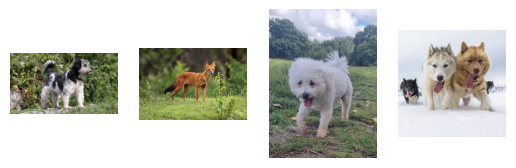

In [ ]:
#view the PIL images before transforms

fig, axs = plt.subplots(1, len(file_list))

for i in range(len(file_list)):
  axs[i].imshow(Image.open(file_list[i]))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [ ]:
transform = v2.Compose([
              v2.Resize(560, interpolation=v2.InterpolationMode.BICUBIC),
              v2.CenterCrop(560),
              v2.ToTensor(),
              v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])

batch_size = len(file_list)
imgs_tensor = torch.zeros(batch_size, 3, 560, 560)

for i in range(batch_size):
    img = Image.open(file_list[i])
    imgs_tensor[i] = transform(img)

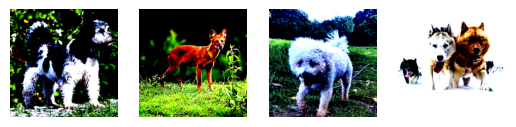

In [ ]:
#view the PIL images after transforms

fig, axs = plt.subplots(1, len(file_list))

for i in range(len(file_list)):
  axs[i].imshow(imgs_tensor[i].permute(1,2,0))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [ ]:
#load large DinoV2 model
torch.cuda.empty_cache() #empty GPU cache before trying different models
#dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
#dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dino.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [ ]:
#Inference
with torch.no_grad():
  features_dict = dino.forward_features(imgs_tensor.cuda())
  features = features_dict['x_norm_patchtokens']
  #features = features_dict['x_prenorm']

print("before reshape", features.shape)
_, n_patch, dim = features.shape
features = features.reshape(batch_size*n_patch, dim)
print("after reshape", features.shape)

OutOfMemoryError: CUDA out of memory. Tried to allocate 940.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 302.88 MiB is free. Process 8004 has 21.87 GiB memory in use. Of the allocated memory 21.11 GiB is allocated by PyTorch, and 549.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#def minmax_norm(x):
#    """Min-max normalization"""
#    return (x - x.min(0).values) / (x.max(0).values - x.min(0).values)

#def normalize_tensor(t):
#    return (t - t.min()) / (t.max() - t.min())

In [ ]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
features.shape

torch.Size([6400, 1536])

In [ ]:
features = features.cpu()
pca = PCA(n_components=1)
scaler = MinMaxScaler()
pca.fit(features)
pca_features = pca.transform(features)
norm_features = scaler.fit_transform(pca_features)

In [ ]:
pca_features.shape

(6400, 1)

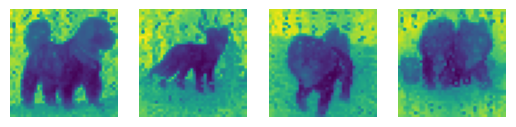

In [ ]:
#view the normalized features after transforms

fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = pca_features[i * n_patch: (i+1) * n_patch, 0].reshape(40, 40)
  axs[i].imshow(img)
  axs[i].axis('off')  # Turn off axis labels

plt.show()

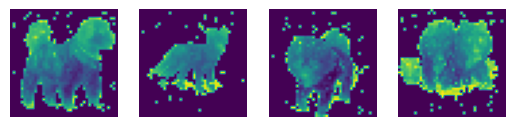

In [ ]:

# Remove background
threshold = 0.5 #for ViTl/14
#threshold = 0.4 #for ViTg/14
background = norm_features > threshold #Adjust threshold based on your images
#background= ~foreground

fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = norm_features[i * n_patch: (i+1) * n_patch]
  #mask = background[i * n_patch: (i+1) * n_patch]
  img[img>threshold] = 0
  axs[i].imshow(img.reshape(40, 40))
  axs[i].axis('off')  # Turn off axis labels

plt.show()


In [ ]:
#features[:,i].shape
#background[:,0].shape

In [ ]:
#set background of features to zero

bg_features = features.clone() #make a copy of features
for i in range(bg_features.shape[-1]):
  bg_features[:,i][background[:,0]] = 0

In [ ]:
pca3 = PCA(n_components=3)
pca3.fit(bg_features)
features_foreground = pca3.transform(bg_features)
norm_features_foreground = scaler.fit_transform(features_foreground)

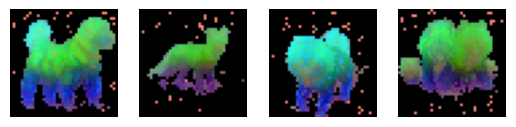

In [ ]:
fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = norm_features_foreground[i * n_patch: (i+1) * n_patch]
  mask = background[i * n_patch: (i+1) * n_patch]
  for j in range(3):
    img[:,j][mask[:,0]]=0
  axs[i].imshow(img.reshape(40, 40,3))
  axs[i].axis('off')  # Turn off axis labels

plt.show()